In [1]:
import matplotlib.pyplot as plt
from src.dataset.TrainDataLoader import TrainDataLoader
from torchvision import transforms

%matplotlib inline

dataset_path = '/mnt/clef/imageclef_2016/train'
labels_path = '/mnt/biomedical-image-classification/labels/clef16_train.csv' 
seed = 443

In [2]:
classes = ['MICROSCOPY', 'GRAPHICS', 'ORGANISMS', 'MOLECULAR', 'EXPERIMENTAL', 'OTHER']
classes.sort()
provider = TrainDataLoader(dataset_path, labels_path, classes, seed=seed)

In [3]:
train_dataset = provider.get_train_dataset()
val_dataset = provider.get_val_dataset()

In [4]:
train_dataset.codec.classes_

array(['EXPERIMENTAL', 'GRAPHICS', 'MICROSCOPY', 'MOLECULAR', 'ORGANISMS',
       'OTHER'], dtype='<U12')

In [5]:
image, label, name = train_dataset[200]

In [6]:
train_dataset.codec.inverse_transform([label])

array(['GRAPHICS'], dtype='<U12')

In [7]:
print(name)
img = image.permute(1, 2, 0)

inv_normalize = transforms.Normalize(
   mean=[-0.7364/0.3538, -0.7319/0.3543, -0.7295/0.3593],
   std=[1/0.3538, 1/0.3543, 1/0.3593]
)
inv_tensor = inv_normalize(image)


/mnt/clef/imageclef_2016/train/GFIG/1471-2091-10-3-3-2.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


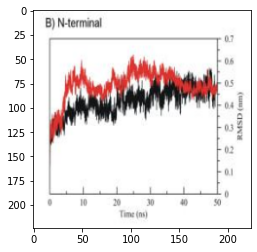

In [8]:
plt.imshow(inv_tensor.permute(1, 2, 0))

In [9]:
import os

model_name = 'ruby-haze-5'
weights = os.path.join('/mnt/models/high-level-modality', model_name, 'checkpoint.pt') 

In [10]:
from torchvision import models
import torch
import torch.nn as nn

model = models.resnet34(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))

model.load_state_dict(torch.load(weights))

<All keys matched successfully>

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
model = model.to(device)

In [13]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
from torch.utils.data import DataLoader

valid_loss, valid_n_iter = 0, 0
total, correct = 0, 0

kwargs = {'num_workers': 16, 'pin_memory': True} if torch.cuda.is_available() else {}
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, **kwargs)

pred = []
gt = []
names = []

for images, labels, img_names in valid_loader:
    names += img_names
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    pred += list(predicted.cpu().numpy())
    gt += list(labels.cpu().numpy())

    total += labels.size(0)
    correct += torch.sum(predicted == labels.data)
    valid_n_iter += 1

epoch_acc = 100 * correct / total

In [15]:
len(pred), len(gt), len(names)

(1348, 1348, 1348)

In [64]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
cm = confusion_matrix(np.asarray(gt), np.asarray(pred), labels=[0,1,2,3,4,5])

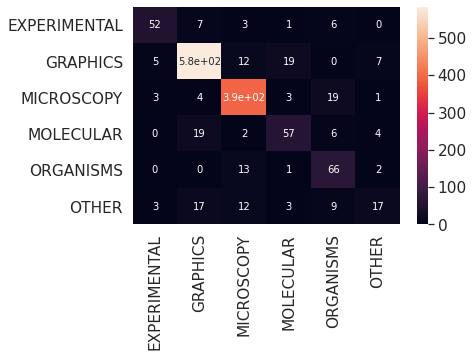

In [68]:
import seaborn as sn
import pandas as pd

df_cm = pd.DataFrame(cm, train_dataset.codec.classes_, train_dataset.codec.classes_)

sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size

plt.show()

In [35]:
incorrect = []
bad_pred = []
bad_gt = []
for y_pred, y_true, img_name in zip(pred, gt, names):
    if y_pred != y_true:
        incorrect.append(img_name)
        bad_pred.append(y_pred)
        bad_gt.append(y_true)

IndexError: index 20 is out of bounds for axis 0 with size 20

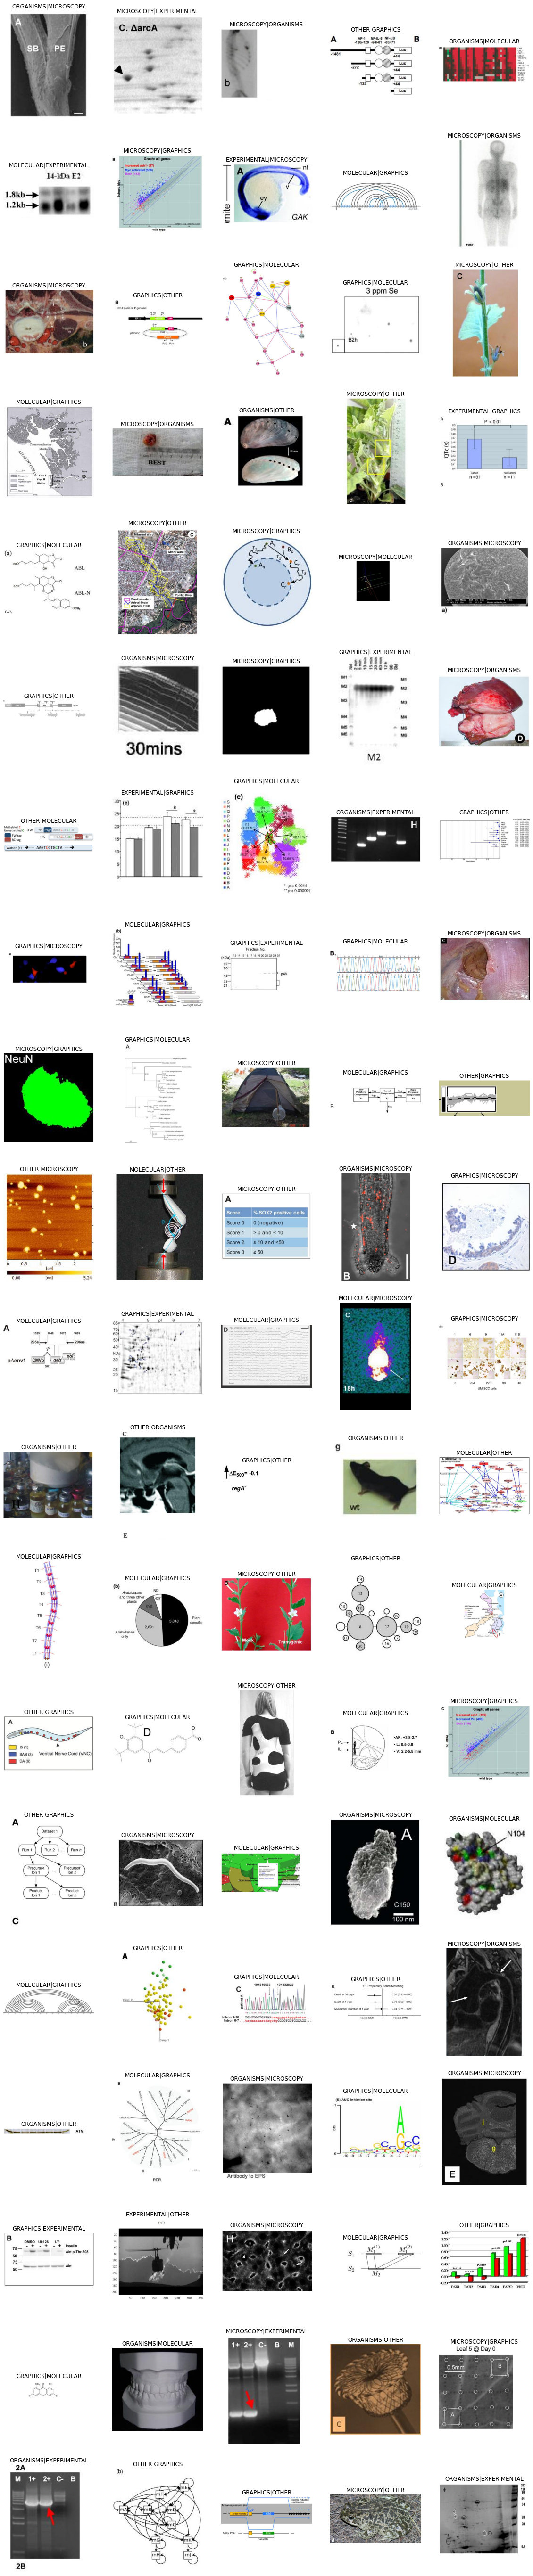

In [43]:
from skimage import io

bad_pred_t = train_dataset.codec.inverse_transform(bad_pred)
bad_gt_t = train_dataset.codec.inverse_transform(bad_gt)

num_lines = 20
f, axarr = plt.subplots(num_lines,5, figsize=(20, 100))
for i in range(len(incorrect)):
    col = i % 5
    row = i // 5
    axarr[row, col].imshow(io.imread(incorrect[i]))
    axarr[row, col].axis('off')
    axarr[row, col].set_title(bad_pred_t[i] + "|" + bad_gt_t[i])